In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxopt
from sklearn.svm import SVC
from scipy.spatial.distance import cdist
import time

### Regularized linear regression

In [2]:
class LinearRegression():
    def __init__(self, ld=0):
        self.ld = ld
    
    def fit(self, X, y):
        M, N = X.shape
        self.w = np.linalg.inv(X.T @ X + self.ld * np.eye(N)) @ (X.T) @ y
        
    def predict(self, X):
        pred = X @ self.w
        return pred.squeeze()

In [3]:
def error(y_true, y_pred):
    mul = y_true * y_pred
    return np.sum(mul < 0) / len(y_true)

def transform(X, funcs, keep_cols=True):
    """
    Inputs:
    - X: input nd-array
    - funcs: a list of functions applied on input's columns
    
    Return: a new input matrix with new features
    """
    
    for f in funcs:
        newcol = f(X).reshape(-1,1)
        X = np.hstack((X, newcol))
    if not keep_cols:
        X = X[:, X.shape[1]-len(funcs):]
    return X

def one_vs_one(X, y, a, b):
    y_reduced = y[(y==a) | (y==b)]
    X_reduced = X[(y==a) | (y==b)]
    y_cp = y_reduced.copy()
    y_cp[y_reduced==a] = 1
    y_cp[y_reduced==b] = -1
    return X_reduced, y_cp

def one_vs_all(y, a):
    y_cp = y.copy()
    y_cp[y==a] = 1
    y_cp[y!=a] = -1
    return y_cp

In [4]:
train_df = pd.read_table('datasets/features.train', header=None, sep='  ', engine='python')
test_df = pd.read_table('datasets/features.test', header=None, sep='  ', engine='python')

In [5]:
print(train_df.shape, test_df.shape)

(7291, 3) (2007, 3)


In [6]:
X_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]

X_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

X_train = np.hstack((np.ones((len(X_train),1)), X_train))
X_test = np.hstack((np.ones((len(X_test),1)), X_test))

#### Question 7

In [7]:
for k in [5, 6, 7, 8, 9]:
    y_train_tmp = one_vs_all(y_train, k)
    lr = LinearRegression(ld=1)
    lr.fit(X_train, y_train_tmp)
    pred = lr.predict(X_train)
    Ein = error(y_train_tmp, pred)
    print('{}-vs-all classifier: Ein = {:.4f}'.format(k, Ein))

5-vs-all classifier: Ein = 0.0763
6-vs-all classifier: Ein = 0.0911
7-vs-all classifier: Ein = 0.0885
8-vs-all classifier: Ein = 0.0743
9-vs-all classifier: Ein = 0.0883


#### Question 8

In [8]:
nonlinear_trans = [lambda x: x[:,1]*x[:,2],
                  lambda x: x[:,1]**2,
                  lambda x: x[:,2]**2]

for k in range(5):
    X_train_tmp = transform(X_train, nonlinear_trans)
    y_train_tmp = one_vs_all(y_train, k)
    X_test_tmp = transform(X_test, nonlinear_trans)
    y_test_tmp = one_vs_all(y_test, k)
    lr = LinearRegression(ld=1)
    lr.fit(X_train_tmp, y_train_tmp)
    pred_test = lr.predict(X_test_tmp)
    Eout = error(y_test_tmp, pred_test)
    print('{}-vs-all classifier: Eout = {:.4f}'.format(k, Eout))

0-vs-all classifier: Eout = 0.1066
1-vs-all classifier: Eout = 0.0219
2-vs-all classifier: Eout = 0.0987
3-vs-all classifier: Eout = 0.0827
4-vs-all classifier: Eout = 0.0997


#### Question 9

In [9]:
for k in range(10):
    X_train_trans = transform(X_train, nonlinear_trans)
    X_test_trans = transform(X_test, nonlinear_trans)
    y_train_tmp = one_vs_all(y_train, k)
    y_test_tmp = one_vs_all(y_test, k)
    
    
    lr_nontrans = LinearRegression(ld=1)
    lr_nontrans.fit(X_train, y_train_tmp)
    pred_train_nontrans = lr_nontrans.predict(X_train)
    pred_test_nontrans = lr_nontrans.predict(X_test)
    Ein_nontrans = error(y_train_tmp, pred_train_nontrans)
    Eout_nontrans = error(y_test_tmp, pred_test_nontrans)
    
    lr_trans = LinearRegression(ld=1)
    lr_trans.fit(X_train_trans, y_train_tmp)
    pred_train_trans = lr_trans.predict(X_train_trans)
    pred_test_trans = lr_trans.predict(X_test_trans)
    Ein_trans = error(y_train_tmp, pred_train_trans)
    Eout_trans = error(y_test_tmp, pred_test_trans)
    
    print('* {}-vs-all classifier:'.format(k))
    print('\t- without transformation: Ein = {:.4f}, Eout = {:.4f}'.format(Ein_nontrans, Eout_nontrans))
    print('\t- with transformation: Ein = {:.4f}, Eout = {:.4f}'.format(Ein_trans, Eout_trans))
    print('\t- Improvement for Eout: Eout (transformed)/Eout (nontransformed) = {:.3f}\n'.format(Eout_trans/Eout_nontrans))

* 0-vs-all classifier:
	- without transformation: Ein = 0.1093, Eout = 0.1151
	- with transformation: Ein = 0.1023, Eout = 0.1066
	- Improvement for Eout: Eout (transformed)/Eout (nontransformed) = 0.926

* 1-vs-all classifier:
	- without transformation: Ein = 0.0152, Eout = 0.0224
	- with transformation: Ein = 0.0123, Eout = 0.0219
	- Improvement for Eout: Eout (transformed)/Eout (nontransformed) = 0.978

* 2-vs-all classifier:
	- without transformation: Ein = 0.1003, Eout = 0.0987
	- with transformation: Ein = 0.1003, Eout = 0.0987
	- Improvement for Eout: Eout (transformed)/Eout (nontransformed) = 1.000

* 3-vs-all classifier:
	- without transformation: Ein = 0.0902, Eout = 0.0827
	- with transformation: Ein = 0.0902, Eout = 0.0827
	- Improvement for Eout: Eout (transformed)/Eout (nontransformed) = 1.000

* 4-vs-all classifier:
	- without transformation: Ein = 0.0894, Eout = 0.0997
	- with transformation: Ein = 0.0894, Eout = 0.0997
	- Improvement for Eout: Eout (transformed)/Eout (

#### Question 10

In [10]:
X_train_tmp = transform(X_train, nonlinear_trans)
X_test_tmp = transform(X_test, nonlinear_trans)
X_train_tmp, y_train_tmp = one_vs_one(X_train_tmp, y_train, 1, 5)
X_test_tmp, y_test_tmp = one_vs_one(X_test_tmp, y_test, 1, 5)

for ld in [.01, 1]:
    lr = LinearRegression(ld)
    lr.fit(X_train_tmp, y_train_tmp)
    pred_train = lr.predict(X_train_tmp)
    pred_test = lr.predict(X_test_tmp)
    Ein = error(y_train_tmp, pred_train)
    Eout = error(y_test_tmp, pred_test)
    print('Lambda = {}: Ein = {:.4f}, Eout = {:.4f}'.format(ld, Ein, Eout))

Lambda = 0.01: Ein = 0.0045, Eout = 0.0283
Lambda = 1: Ein = 0.0051, Eout = 0.0259


### Support vector machines

In [11]:
X = np.array([[1, 0],
             [0, 1],
             [0, -1],
             [-1, 0],
             [0, 2],
             [0, -2],
             [-2, 0]])

y = np.array([-1, -1, -1, 1, 1, 1, 1])

In [12]:
Z = transform(X, [lambda x: x[:,1]**2 - 2*x[:,0] - 1, lambda x: x[:,0]**2 - 2*x[:,1] + 1], keep_cols=False)

#### Question 11

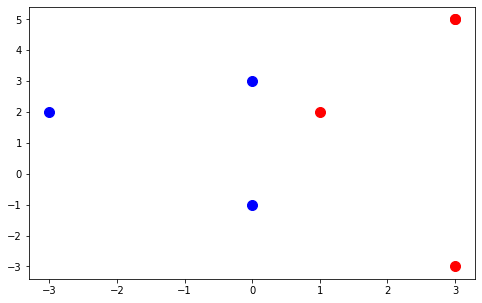

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(Z[y==-1,0], Z[y==-1,1], 'bo', markersize=10, label='class -1')
plt.plot(Z[y==1,0], Z[y==1,1], 'ro', markersize=10, label='class 1')
plt.show()

#### Question 12

In [14]:
class SVM():
    def __init__(self, kernel='linear', degree=1, gamma=1):
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        
    def fit(self, X, y):
        self.X = X
        if self.kernel == 'linear':
            K = X @ X.T
        elif self.kernel == 'poly':
            K = (1 + X @ X.T)**self.degree
        elif self.kernel == 'rbf':
            K = np.ndarray((X.shape[0], X.shape[0]))
            for i in range(X.shape[0]):
                for j in range(X.shape[0]):
                    K[i, j] = np.exp(-self.gamma * np.linalg.norm(X[i] - X[j])**2)
                    
        cvxopt.solvers.options['show_progress'] = False
        y = y.reshape(-1,1)
        P = (y @ y.T) * K
        q = -np.ones(len(y))
        G = -np.eye(len(y))
        h = np.zeros((len(y),1))
        A = y.T
        b = np.zeros(1)

        P = cvxopt.matrix(P, tc='d')
        q = cvxopt.matrix(q, tc='d')
        G = cvxopt.matrix(G, tc='d')
        h = cvxopt.matrix(h, tc='d')
        A = cvxopt.matrix(A, tc='d')
        b = cvxopt.matrix(b, tc='d')
        cvx = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alpha = np.around(np.array(cvx['x']), decimals = 5)
        self.w = (y * K).T @ self.alpha
        self.sv_idx = [i for i in range(len(self.alpha)) if self.alpha[i] > 0]
        if len(self.sv_idx) == 0:
            self.sv_idx.append(0)

        # KKT condition
        self.b = y[self.sv_idx[0]] - np.sum(self.alpha[:,0] * y[:,0] * K[:, self.sv_idx[0]])
        self.y = y
    def predict(self, X):
        if self.kernel == 'linear':
            K = X @ self.X.T
        elif self.kernel == 'poly':
            K = (1 + X @ self.X.T)**self.degree
        elif self.kernel == 'rbf':
            K = np.ndarray((X.shape[0], self.X.shape[0]))
            for i in range(X.shape[0]):
                for j in range(self.X.shape[0]):
                    K[i, j] = np.exp(-self.gamma * np.linalg.norm(X[i] - self.X[j])**2)
                    
        
        return np.sign(K @ (self.y[:,0]*self.alpha[:,0]).reshape(-1,1)  + self.b).squeeze()

In [15]:
X = np.array([[1, 0],
             [0, 1],
             [0, -1],
             [-1, 0], 
             [0, 2],
             [0, -2],
             [-2, 0]])

y = np.array([-1, -1, -1, 1, 1, 1, 1])
svm = SVM('poly', 2)
svm.fit(X, y)
print('Number of support vectors: {}'.format(np.sum(svm.alpha>0)))

Number of support vectors: 5


### Radial basis function

In [16]:
def generate_data(n_points=100):
    X = np.random.uniform(-1, 1, (n_points, 2))
    f = np.sign(X[:,1] - X[:,0] + .25*np.sin(np.pi*X[:,0]))
    return X, f

#### Question 13

In [17]:
n_runs = 1000
print('Running {} times...'.format(n_runs))
gamma = 1.5
notseparable_count = 0
start = time.time()
for n in range(n_runs):
    X, f = generate_data(100)
    svm = SVM(kernel='rbf', gamma=gamma)
    svm.fit(X, f)
    pred = svm.predict(X)
    if error(f, pred) > 0:
        notseparable_count += 1
print('Execution finished, time = {:.3f}s'.format(time.time() - start)       ) 
print('Percentage of times data is not separable by RBF kernel: {:.2f}%'.format(notseparable_count/n_runs*100))

Running 1000 times...
Execution finished, time = 224.872s
Percentage of times data is not separable by RBF kernel: 0.10%


#### Question 14

In [18]:
class RegularRBF():
    def __init__(self, n_clusters=3, gamma=1):
        self.n_clusters = n_clusters
        self.gamma = gamma
        
    def fit(self, X, y):
        self.X = X
        self.centers = self.init_centers()
        self.get_cluster()
        self.KMeans()
        self.phi = np.exp(-self.gamma * cdist(self.X, self.centers)**2)
        self.phi = np.hstack((np.ones((self.X.shape[0],1)), self.phi))
        self.w = np.linalg.inv(self.phi.T @ self.phi) @ self.phi.T @ y
        
    def init_centers(self):
        self.clusters = np.zeros(len(self.X))
        C = np.random.uniform(-1.,1., size=(self.n_clusters, X.shape[1]))
        return C
    
    def get_cluster(self):
        for i in range(len(self.X)):
            self.clusters[i] = np.argmin(cdist(X[i,None], self.centers))
            
    def KMeans(self):
        self.converged = False
        self.iter_kmeans = 0
        while not self.converged:
            self.iter_kmeans += 1
            if self.iter_kmeans >= 100:
                self.centers = self.init_centers()
                self.get_cluster()
                self.iter_kmeans = 0
                continue
            prev_centers = self.centers.copy()
            for k in range(self.n_clusters):
                self.centers[k] = np.mean(X[self.clusters==k, :], axis=0)
            self.get_cluster()
            if np.array_equal(prev_centers, self.centers):
                self.converged = True
                for i in range(self.n_clusters):
                    n_ci = np.sum(self.clusters == i)
                    if n_ci == 0:
                        self.centers = self.init_centers()
                        self.get_cluster()
                        self.iter_kmeans = 0
                        self.converged = False
                        continue
                
                
    def predict(self, X):
        phi = np.exp(-self.gamma * cdist(X, self.centers)**2)
        phi = np.hstack((np.ones((X.shape[0],1)), phi))
        return np.sign(phi @ self.w)

In [19]:
n_runs = 1000
print('Running {} times...'.format(n_runs))
gamma = 1.5
K = 9
kernelbeat_cnt = 0
cnt = 0
start = time.time()
for n in range(n_runs):
    X_train, y_train = generate_data(100)
    X_test, y_test = generate_data(100)
    
    svm = SVM(kernel='rbf', gamma=gamma)
    svm.fit(X_train, y_train)
    regRBF = RegularRBF(n_clusters=K, gamma=gamma)
    regRBF.fit(X_train, y_train)
    
    pred_svm = svm.predict(X_test)
    pred_rbf = regRBF.predict(X_test)
    if error(y_test, pred_svm) < error(y_test, pred_rbf):
        kernelbeat_cnt += 1
print('Execution finished, time = {:.3f}s'.format(time.time() - start)) 
print('Percentage of times kernel form beats regular form: {:.2f}%'.format(kernelbeat_cnt/n_runs*100))

Running 1000 times...


/Users/tungo/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tungo/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Execution finished, time = 271.043s
Percentage of times kernel form beats regular form: 71.60%


#### Question 15

In [20]:
n_runs = 1000
print('Running {} times...'.format(n_runs))
gamma = 1.5
K = 12
kernelbeat_cnt = 0
start = time.time()
for n in range(n_runs):
    X_train, y_train = generate_data(100)
    X_test, y_test = generate_data(100)
    
    svm = SVM(kernel='rbf', gamma=gamma)
    svm.fit(X_train, y_train)
    regRBF = RegularRBF(n_clusters=K, gamma=gamma)
    regRBF.fit(X_train, y_train)
    
    pred_svm = svm.predict(X_test)
    pred_rbf = regRBF.predict(X_test)
    if error(y_test, pred_svm) < error(y_test, pred_rbf):
        kernelbeat_cnt += 1
print('Execution finished, time = {:.3f}s'.format(time.time() - start)) 
print('Percentage of times kernel form beats regular form: {:.2f}%'.format(kernelbeat_cnt/n_runs*100))

Running 1000 times...
Execution finished, time = 305.282s
Percentage of times kernel form beats regular form: 60.40%


#### Question 16

In [21]:
n_runs = 1000
print('Running {} times...'.format(n_runs))
gamma = 1.5
K1, K2 = 9, 12
Ein_up_cnt, Ein_down_cnt, Ein_same_cnt = 0, 0, 0
Eout_up_cnt, Eout_down_cnt, Eout_same_cnt = 0, 0, 0
start = time.time()
for n in range(n_runs):
    X_train, y_train = generate_data(100)
    X_test, y_test = generate_data(100)
    
    rbf1 = RegularRBF(K1, gamma)
    rbf1.fit(X_train, y_train)
    
    rbf2 = RegularRBF(K2, gamma)
    rbf2.fit(X_train, y_train)
    
    pred_train1 = rbf1.predict(X_train)
    pred_train2 = rbf2.predict(X_train)
    pred_test1 = rbf1.predict(X_test)
    pred_test2 = rbf2.predict(X_test)
    
    Ein1 = error(y_train, pred_train1)
    Ein2 = error(y_train, pred_train2)
    Eout1 = error(y_test, pred_test1)
    Eout2 = error(y_test, pred_test2)
    
    if Ein2 > Ein1:
        Ein_up_cnt +=1
    elif Ein2 == Ein1:
        Ein_same_cnt += 1
    else:
        Ein_down_cnt += 1
        
    if Eout2 > Eout1:
        Eout_up_cnt +=1
    elif Eout2 == Eout1:
        Eout_same_cnt += 1
    else:
        Eout_down_cnt += 1
print('Execution finished, time = {:.3f}s'.format(time.time() - start))
print()
print('- Ein goes up: {:.2f}%'.format(Ein_up_cnt/n_runs*100))
print('- Ein goes down: {:.2f}%'.format(Ein_down_cnt/n_runs*100))
print('- Ein keeps the same: {:.2f}%'.format(Ein_same_cnt/n_runs*100))
print('- Eout goes up: {:.2f}%'.format(Eout_up_cnt/n_runs*100))
print('- Eout goes down: {:.2f}%'.format(Eout_down_cnt/n_runs*100))
print('- Eout keeps the same: {:.2f}%'.format(Eout_same_cnt/n_runs*100))

Running 1000 times...
Execution finished, time = 88.217s

- Ein goes up: 0.00%
- Ein goes down: 100.00%
- Ein keeps the same: 0.00%
- Eout goes up: 0.00%
- Eout goes down: 100.00%
- Eout keeps the same: 0.00%


#### Question 17

In [23]:
n_runs = 1000
print('Running {} times...'.format(n_runs))
gamma1, gamma2 = 1.5, 2
K = 9
Ein_up_cnt, Ein_down_cnt, Ein_same_cnt = 0, 0, 0
Eout_up_cnt, Eout_down_cnt, Eout_same_cnt = 0, 0, 0
start = time.time()
for n in range(n_runs):
    X_train, y_train = generate_data(100)
    X_test, y_test = generate_data(100)
    
    rbf1 = RegularRBF(K, gamma1)
    rbf1.fit(X_train, y_train)
    
    rbf2 = RegularRBF(K, gamma2)
    rbf2.fit(X_train, y_train)
    
    pred_train1 = rbf1.predict(X_train)
    pred_train2 = rbf2.predict(X_train)
    pred_test1 = rbf1.predict(X_test)
    pred_test2 = rbf2.predict(X_test)
    
    Ein1 = error(y_train, pred_train1)
    Ein2 = error(y_train, pred_train2)
    Eout1 = error(y_test, pred_test1)
    Eout2 = error(y_test, pred_test2)
    
    if Ein2 > Ein1:
        Ein_up_cnt +=1
    elif Ein2 == Ein1:
        Ein_same_cnt += 1
    else:
        Ein_down_cnt += 1
        
    if Eout2 > Eout1:
        Eout_up_cnt +=1
    elif Eout2 == Eout1:
        Eout_same_cnt += 1
    else:
        Eout_down_cnt += 1
print('Execution finished, time = {:.3f}s'.format(time.time() - start))
print()
print('- Ein goes up: {:.2f}%'.format(Ein_up_cnt/n_runs*100))
print('- Ein goes down: {:.2f}%'.format(Ein_down_cnt/n_runs*100))
print('- Ein keeps the same: {:.2f}%'.format(Ein_same_cnt/n_runs*100))
print('- Eout goes up: {:.2f}%'.format(Eout_up_cnt/n_runs*100))
print('- Eout goes down: {:.2f}%'.format(Eout_down_cnt/n_runs*100))
print('- Eout keeps the same: {:.2f}%'.format(Eout_same_cnt/n_runs*100))

Running 1000 times...
Execution finished, time = 78.327s

- Ein goes up: 45.80%
- Ein goes down: 31.30%
- Ein keeps the same: 22.90%
- Eout goes up: 42.80%
- Eout goes down: 39.60%
- Eout keeps the same: 17.60%


#### Question 18

In [24]:
n_runs = 1000
print('Running {} times...'.format(n_runs))
gamma = 1.5
K = 9
perfect_cnt = 0
start = time.time()
for n in range(n_runs):
    X_train, y_train = generate_data(100)
    
    regRBF = RegularRBF(n_clusters=K, gamma=gamma)
    regRBF.fit(X_train, y_train)
    
    pred = regRBF.predict(X_train)
    if error(y_train, pred) == 0:
        perfect_cnt += 1
print('Execution finished, time = {:.3f}s'.format(time.time() - start)) 
print('Percentage of times Ein=0: {:.2f}%'.format(perfect_cnt/n_runs*100))

Running 1000 times...
Execution finished, time = 45.125s
Percentage of times Ein=0: 4.40%
